In [145]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [146]:
# experiments
from experiments.run_sweep import run_sweep
from experiments.run_experiment import TrainingConfig, EvaluateConfig
from experiments.sweep_plots import plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_plots_helpper import taxi_training_plot_specs, taxi_evaluation_plot_specs


# environments
from environments.taxi_v3 import TaxiV3Config, get_taxi_v3_env

# SARSA confirmation bias agent
from agents.sarsa_td0_confirmation_bias import (
    SarsaTD0ConfirmationBiasConfig,
    SarsaTD0ConfirmationBiasAgent,
)

# metrics for training
from metrics.reward_mertrics import taxi_v3_reward_metrics_specs
from metrics.frustration_metrics import frustration_metrics_specs

# external libraries
import numpy as np

In [147]:
BASE_AGENT_CONFIG_CONF = dict(
    alpha_conf=0.2,
    alpha_disconf=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=taxi_v3_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
)


BASE_AGENT_CONFIG_POSITITY = dict(
    alpha_positive=0.2,
    alpha_negative=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=taxi_v3_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
)

## Environments

In [148]:
env_config = TaxiV3Config()

## Agents

In [117]:
## Agents
# sarsa_td0 confirmation bias agent
agent_factory = SarsaTD0ConfirmationBiasAgent
frustration_metrics_specs = frustration_metrics_specs()
reward_metrics_specs = taxi_v3_reward_metrics_specs()

sarsa_td0_config = SarsaTD0ConfirmationBiasConfig(**BASE_AGENT_CONFIG_CONF)

## Sweep configuration

In [124]:
base_train = TrainingConfig(
    name="TaxiV3_sarsa_td0",
    num_train_episodes=50000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="TaxiV3_sarsa_td0",
    num_eval_episodes=5000,  # use >0 if you want eval outputs
    env_kwargs={"config": env_config},
    evaluation_metrics=reward_metrics_specs
)

## Confirmation bias results

In [125]:
def generate_alpha_pairs(
    balanced_lr: float | list[float], num_pairs: int, step_size: float
):
    lrs = balanced_lr if isinstance(balanced_lr, list) else [balanced_lr]

    all_confirmatory_pairs = []
    all_balanced_pairs = []
    all_disconfirmatory_pairs = []

    for lr in lrs:
        confirmatory_pairs = [
            (round(lr + k * step_size, 3), round(lr - k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]
        balanced_pairs = [(round(lr, 3), round(lr, 3))]
        disconfirmatory_pairs = [
            (round(lr - k * step_size, 3), round(lr + k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]

        # Highest confirmatory lr first
        confirmatory_pairs.sort(key=lambda p: p[0], reverse=True)

        all_confirmatory_pairs.extend(confirmatory_pairs)
        all_balanced_pairs.extend(balanced_pairs)
        all_disconfirmatory_pairs.extend(disconfirmatory_pairs)

    return all_confirmatory_pairs, all_balanced_pairs, all_disconfirmatory_pairs

In [126]:
# different q_tables
env = get_taxi_v3_env(env_config)

In [136]:
# create different initial q_tables for the sweep
num_states = env.observation_space.n
num_actions = env.action_space.n

# q table initializations
q0 = np.zeros((num_states, num_actions), dtype=np.float64)
q_pos = np.ones((num_states, num_actions), dtype=np.float64) * 100
q_neg = np.ones((num_states, num_actions), dtype=np.float64) * -100

q_tables = [("zeros", q0)]

confirmatory_pairs, balanced_pairs, disconfirmatory_pairs = generate_alpha_pairs(
    balanced_lr=[0.2], num_pairs=2, step_size=0.025
)

alpha_pairs = confirmatory_pairs + disconfirmatory_pairs
seeds = [1,2]  # 20 different seeds

sweep = {
    "agent_kwargs": [
        {
            "alpha_conf": a_conf,
            "alpha_disconf": a_disconf,
            "seed": seed,
            "initial_q_table": q_table,
            "initial_q_table_label": label,
        }
        for (a_conf, a_disconf) in alpha_pairs
        for (label, q_table) in q_tables
        for seed in seeds
    ],
}

In [137]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_taxi_v3_env,
    agent_factory=agent_factory,
)


In [ ]:
# Confirmation-bias runs where alpha_conf > alpha_disconf
confirmatory_results = [
    r
    for r in results
    if (r.get("params", {}).get("agent_kwargs", {}) or {}).get(
        "alpha_conf", float("-inf")
    )
    > (r.get("params", {}).get("agent_kwargs", {}) or {}).get(
        "alpha_disconf", float("inf")
    )
]

# Keep only seeds 0, 1, 2
first_three_seeds = {0, 1, 2}
confirmatory_first3 = [
    r
    for r in confirmatory_results
    if (r.get("params", {}).get("agent_kwargs", {}) or {}).get("seed")
    in first_three_seeds
]

# Optional: zeros only
confirmatory_zeros = [
    r
    for r in confirmatory_first3
    if (r.get("params", {}).get("agent_kwargs", {}) or {}).get("initial_q_table_label")
    == "zeros"
]

results_to_plot = confirmatory_zeros.copy()
results_to_plot.extend(result_lr)

In [ ]:
# pick one seed value
seed_to_keep = 0

one_seed_results = [
    r
    for r in result_lr
    if (r.get("params", {}).get("agent_kwargs", {}) or {}).get("seed") == seed_to_keep
]

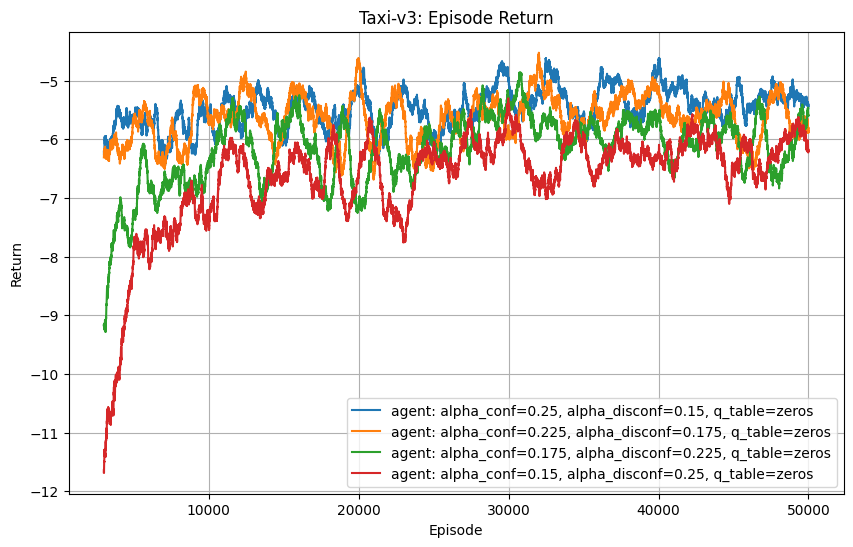

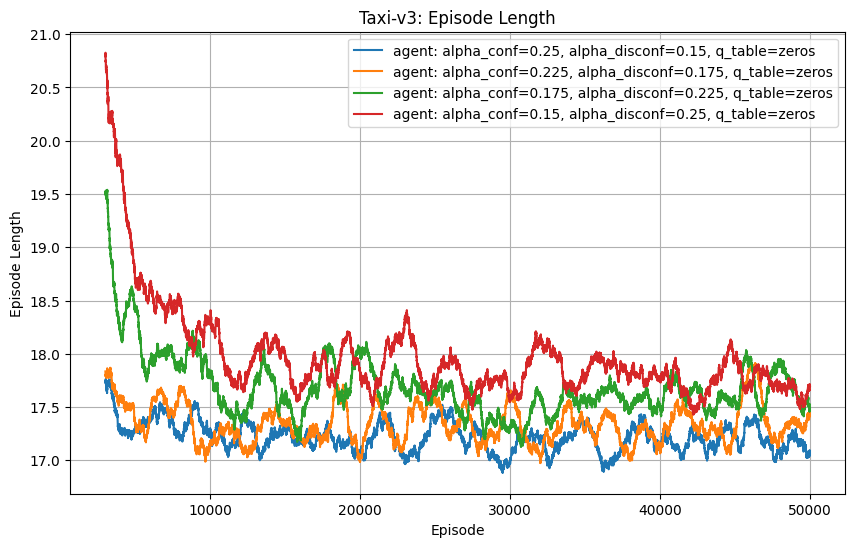

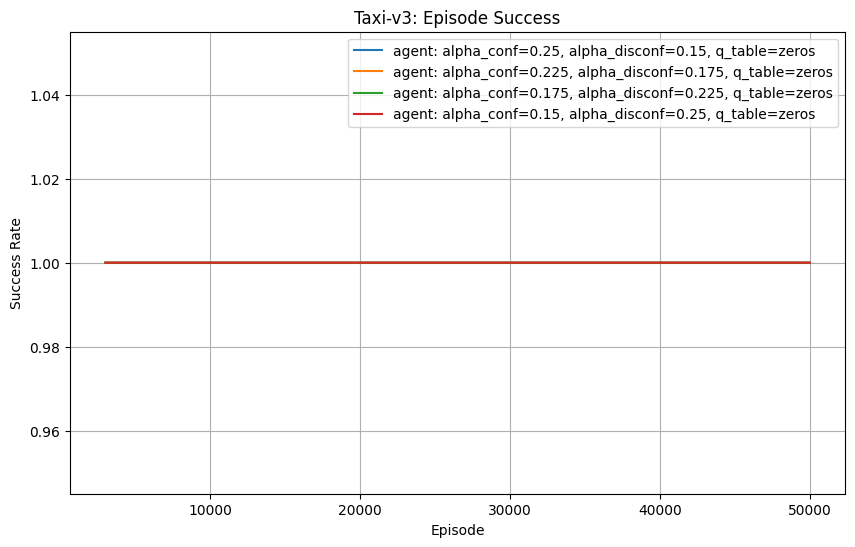

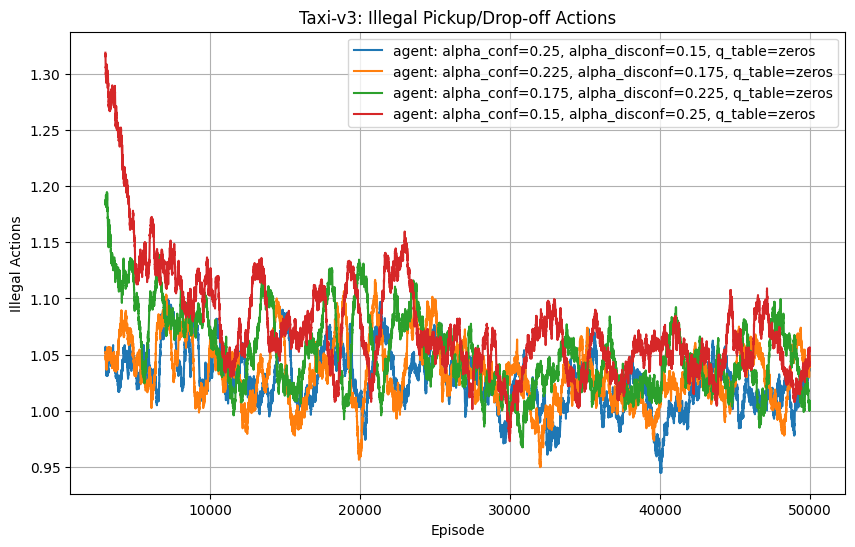

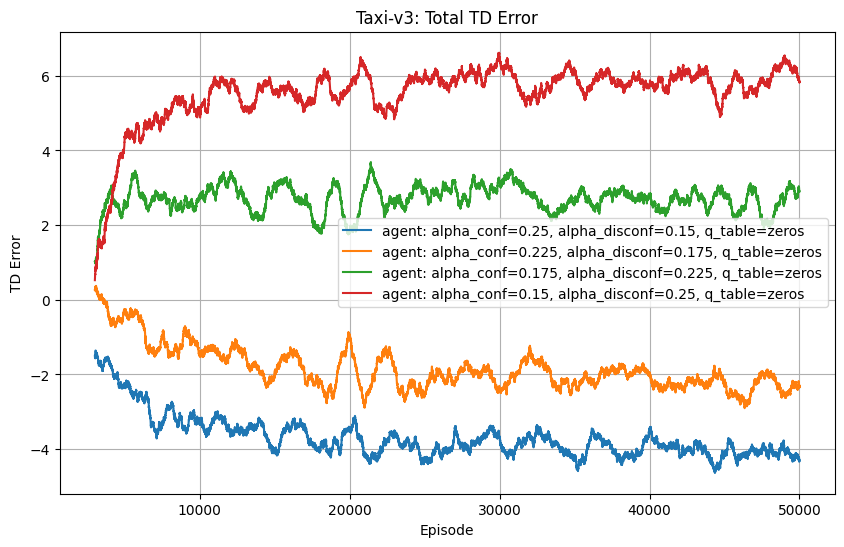

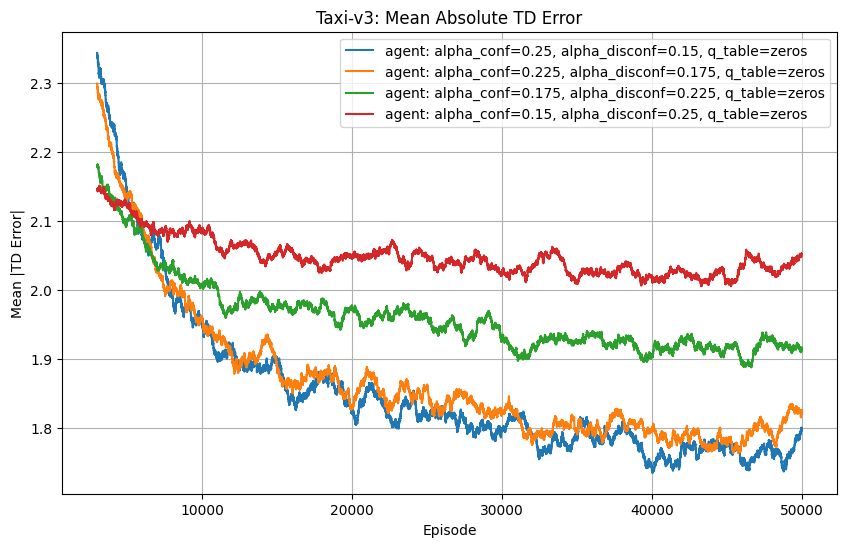

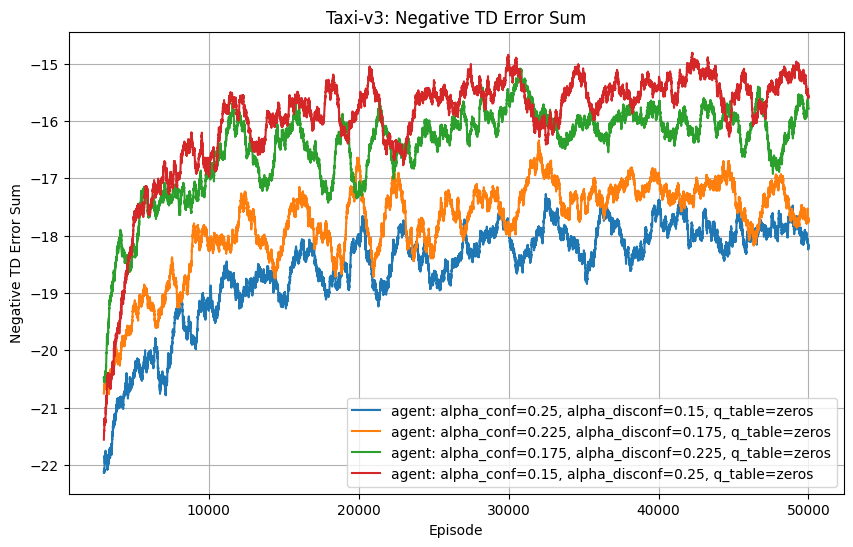

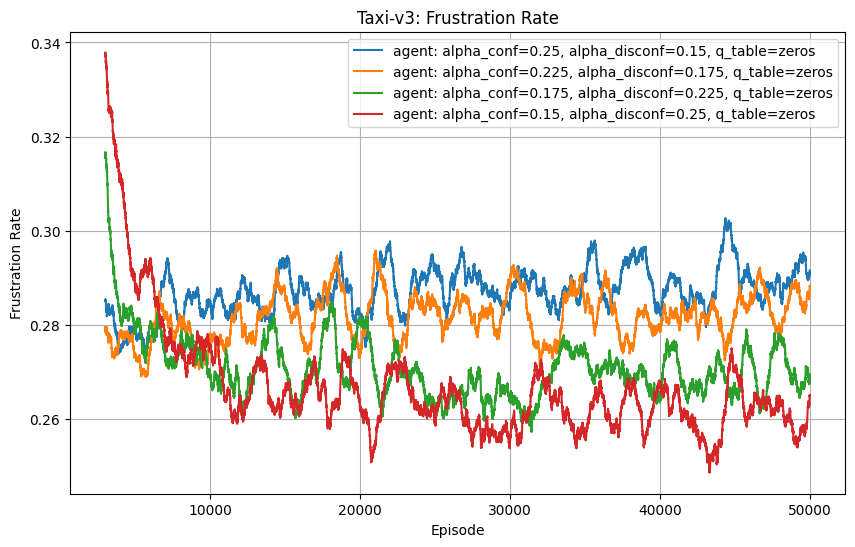

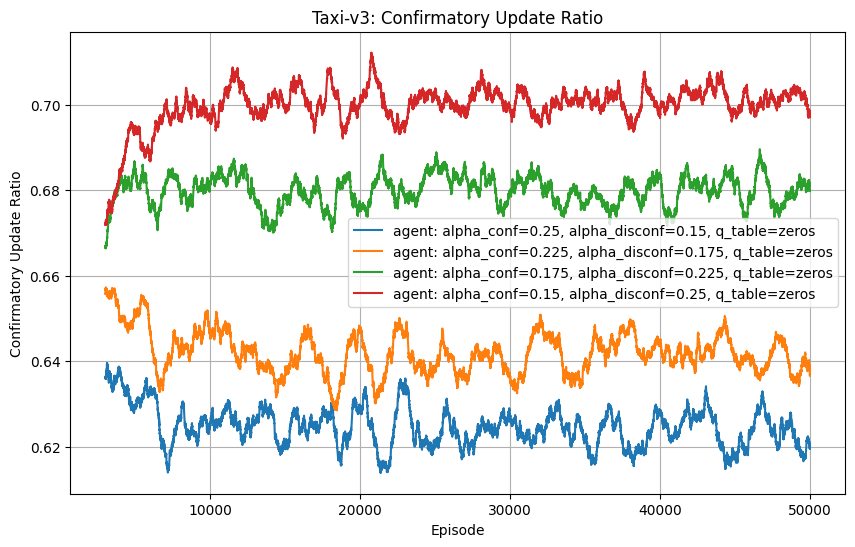

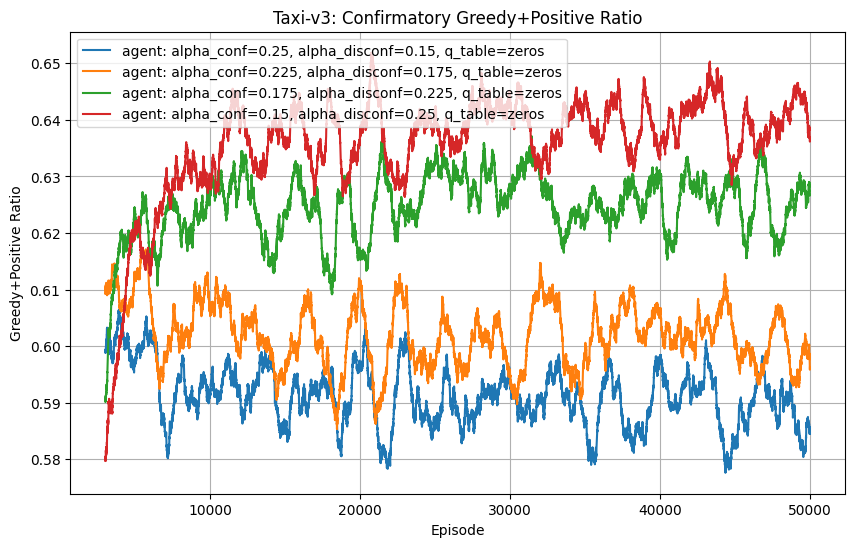

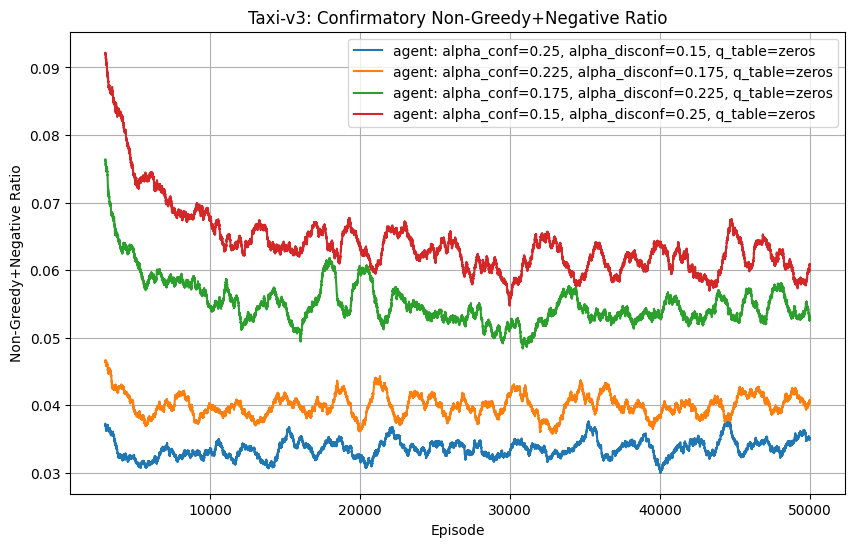

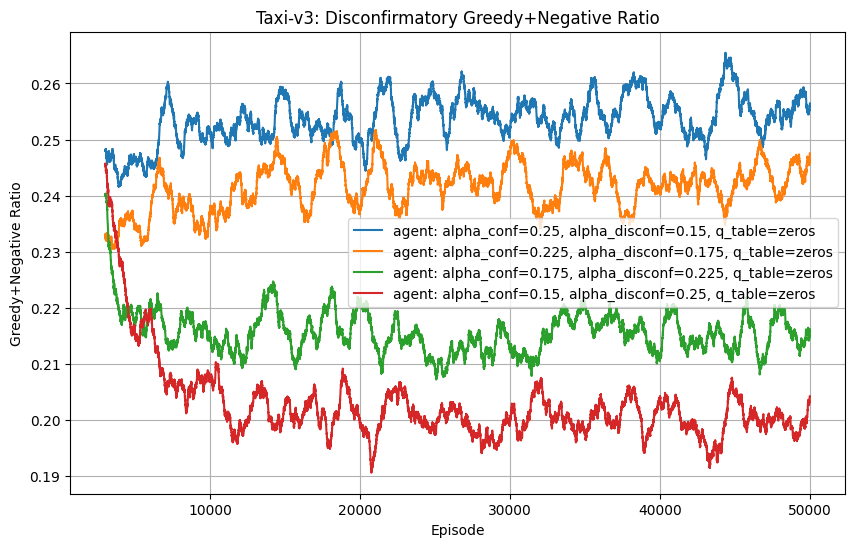

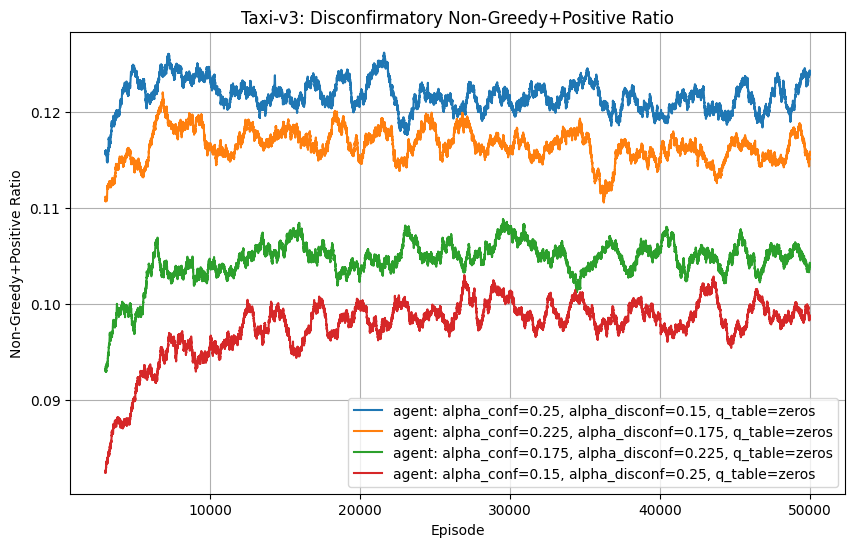

In [138]:
plot_sweep_training(results, 
                    window_size=1000,
                    start_episode=2000,
                    plot_specs=taxi_training_plot_specs()
                    )

In [ ]:
# compare td_error vs td_error_v moving averages for one run
from plots.archive.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


## Positivity bias results

In [157]:
# SARSA positivty bias agent
from agents.sarsa_td0_positivity_bias import (
    SarsaTD0PositivityBiasConfig,
    SarsaTD0PositivityBiasAgent,
)

In [158]:
def asymmetric_alphas(alpha_0: float, ratio: float) -> dict:
    """Return asymmetric step-sizes with a fixed mean and ratio."""
    if alpha_0 <= 0 or ratio <= 0:
        raise ValueError("alpha_0 and ratio must be > 0")

    alpha_negative = round((2.0 * alpha_0) / (ratio + 1.0), 4)
    alpha_positive = round(
        ratio * alpha_negative, 4
    )  # same as 2*alpha_0*ratio/(ratio+1)

    return {"alpha_positive": alpha_positive, "alpha_negative": alpha_negative}

In [159]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0PositivityBiasAgent

sarsa_td0_config = SarsaTD0PositivityBiasConfig(**BASE_AGENT_CONFIG_POSITITY)

In [160]:
base_train = TrainingConfig(
    name="TaxiV3_sarsa_td0",
    num_train_episodes=50000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="TaxiV3_sarsa_td0",
    num_eval_episodes=5000,
    env_kwargs={"config": env_config},
    evaluation_metrics=taxi_v3_reward_metrics_specs(),
)

In [161]:
# different q_tables
env = get_taxi_v3_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

In [155]:
# mean alpha_0 = 0.2
a_0 = 0.2
ratios = [0.8, 0.9, 1.0, 1.1, 1.2]

seeds = list(range())

sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(a_0, r),  # gives alpha_positive / alpha_negative
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for r in ratios
        for seed in seeds
    ],
}

TypeError: range expected at least 1 argument, got 0

In [162]:
import pickle
from pathlib import Path

out_dir = Path("outputs/sweeps")
out_dir.mkdir(parents=True, exist_ok=True)

a_0 = 0.2
ratios = [0.5, 0.75, 1.0, 1.5, 2.0, 4.0]
seeds = list(range(15))

all_results = []
done_ratios = []

for r in ratios:
    out_file = out_dir / f"taxi_pos_ratio_{r}.pkl"

    # Skip already completed ratio runs (resume behavior)
    if out_file.exists():
        print(f"Skipping ratio={r} (already exists): {out_file}")
        with out_file.open("rb") as f:
            ratio_results = pickle.load(f)
        all_results.extend(ratio_results)
        done_ratios.append(r)
        continue

    sweep_one_ratio = {
        "agent_kwargs": [
            {
                **asymmetric_alphas(a_0, r),
                "seed": seed,
                "initial_q_table": q0,
                "initial_q_table_label": "zeros",
            }
            for seed in seeds
        ],
    }

    print(f"Running Taxi ratio={r} with {len(seeds)} seeds...")
    ratio_results = run_sweep(
        base_training=base_train,
        base_evaluation=base_eval,
        sweep=sweep_one_ratio,
        env_factory=get_taxi_v3_env,  # Taxi env factory
        agent_factory=agent_factory,
    )

    # Save immediately after each ratio
    with out_file.open("wb") as f:
        pickle.dump(ratio_results, f)

    all_results.extend(ratio_results)
    done_ratios.append(r)
    print(f"Saved ratio={r} -> {out_file}")

# Optional combined file
combined_file = out_dir / "taxi_pos_all_ratios.pkl"
with combined_file.open("wb") as f:
    pickle.dump(all_results, f)

print(f"Done ratios: {done_ratios}")
print(f"Total runs collected: {len(all_results)}")
print(f"Combined saved to: {combined_file}")

Running Taxi ratio=0.5 with 15 seeds...
Saved ratio=0.5 -> outputs/sweeps/taxi_pos_ratio_0.5.pkl
Running Taxi ratio=0.75 with 15 seeds...
Saved ratio=0.75 -> outputs/sweeps/taxi_pos_ratio_0.75.pkl
Running Taxi ratio=1.0 with 15 seeds...
Saved ratio=1.0 -> outputs/sweeps/taxi_pos_ratio_1.0.pkl
Running Taxi ratio=1.5 with 15 seeds...
Saved ratio=1.5 -> outputs/sweeps/taxi_pos_ratio_1.5.pkl
Running Taxi ratio=2.0 with 15 seeds...
Saved ratio=2.0 -> outputs/sweeps/taxi_pos_ratio_2.0.pkl
Running Taxi ratio=4.0 with 15 seeds...
Saved ratio=4.0 -> outputs/sweeps/taxi_pos_ratio_4.0.pkl
Done ratios: [0.5, 0.75, 1.0, 1.5, 2.0, 4.0]
Total runs collected: 90
Combined saved to: outputs/sweeps/taxi_pos_all_ratios.pkl


In [ ]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_taxi_v3_env,
    agent_factory=agent_factory,
)

In [ ]:
from pathlib import Path
import pickle

out = Path("outputs/sweeps")
out.mkdir(parents=True, exist_ok=True)

file_path = out / "results_pos_bias_copy.pkl"
with open(file_path, "wb") as f:
    pickle.dump(result, f)

print(f"Saved to {file_path}")

In [ ]:
from pathlib import Path
import pickle

file_path = Path("outputs/sweeps/results_lr_15_7_pos_bias.pkl")

with open(file_path, "rb") as f:
    results = pickle.load(f)

In [ ]:
plot_sweep_training(
    results, window_size=100, plot_specs=taxi_training_plot_specs()
)

In [ ]:
plot_sweep_evaluation(results, window_size=300, plot_specs=taxi_evaluation_plot_specs())

In [ ]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)